In [2]:
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch
import os
from coordx import coordx_net

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Helpers

In [61]:
def train(model, optimizer:torch.optim, dims:list[torch.tensor], target:torch.tensor, n_epochs:int, print_step:int=1000):
    '''
    trains the coordx network
    @param model: the model to train
    @param optimizer: the optimizer to use
    @param dims: the input tensors containing the coordinates
    @param target: the target tensor    
    @param n_epochs: number of epochs to train for (20k for image, 100k for video)
    @param print_step: the step to print the loss
    '''
    loss_fn = torch.nn.MSELoss()
    for epoch in range(n_epochs+1):
        optimizer.zero_grad()
        out = model(dims)        
        loss = loss_fn(out, target)
        loss.backward()
        optimizer.step()
        if epoch % print_step == 0:
            print(f'Iteration: {epoch} | Loss: {loss.item()}')

### Image Example

In [112]:
# load dataset
batch_size = 1
transform = transforms.ToTensor()
dataset_train = datasets.Caltech101('data', download=True, transform=transform)
dataloader_train = torch.utils.data.DataLoader(dataset_train,batch_size=batch_size,shuffle=True,num_workers=4)

Files already downloaded and verified


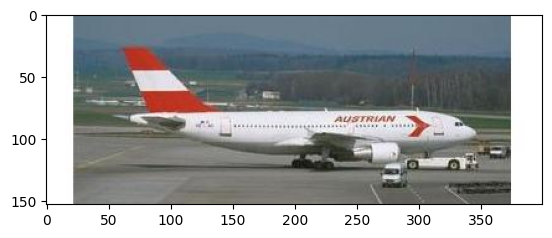

In [58]:
img, _ = next(iter(dataloader_train))
# plot image using maplotlib
plt.imshow(img[0].permute(1, 2, 0))

In [125]:
y_coords = img.shape[2]
x_coords = img.shape[3]

x = torch.linspace(1, x_coords, x_coords).reshape(x_coords,1)
y = torch.linspace(1, y_coords, y_coords).reshape(y_coords,1)

In [126]:
model = coordx_net(n_branches=2, out_channels=3, hidden_size=256).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
img = img.to(device)
x = x.to(device)
y = y.to(device)
train(model=model, optimizer=optimizer, dims=[x,y], target=img[0], n_epochs=1000, print_step=100)

Iteration: 0 | Loss: 0.08088726550340652
Iteration: 100 | Loss: 0.0031493515707552433
Iteration: 200 | Loss: 0.000982980476692319
Iteration: 300 | Loss: 0.000525059353094548
Iteration: 400 | Loss: 0.0003357693203724921
Iteration: 500 | Loss: 0.0002723978250287473
Iteration: 600 | Loss: 0.00018116485443897545
Iteration: 700 | Loss: 0.00014716728765051812
Iteration: 800 | Loss: 0.00021744680998381227
Iteration: 900 | Loss: 0.00010656233644112945
Iteration: 1000 | Loss: 9.574358409736305e-05


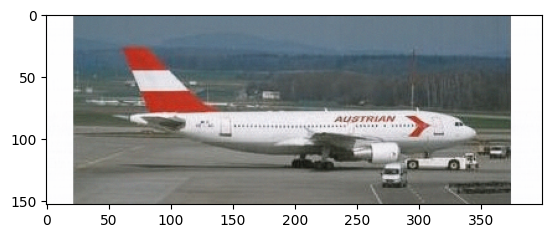

In [127]:
final = model([x,y])
plt.imshow(final.detach().cpu().permute(1, 2, 0).numpy())
plt.show()

### Video Example

In [69]:
# load big buck bunny video 🐇
# (T, H, W, C)
vid = torchvision.io.read_video("videos/bbb.mp4", pts_unit='sec')[0].to(torch.float32)
# make the video small and only a couple seconds long for testing
transform = torchvision.transforms.Resize((64, 128))
vid = transform(vid.permute(0,3,1,2)).permute(0,2,3,1)[15:30,:,:,:]

In [70]:
t_coords = vid.shape[0]
y_coords = vid.shape[1]
x_coords = vid.shape[2]

x = torch.linspace(1, x_coords, x_coords).reshape(x_coords,1)
y = torch.linspace(1, y_coords, y_coords).reshape(y_coords,1)
t = torch.linspace(1, t_coords, t_coords).reshape(t_coords,1)

In [ ]:
model = coordx_net(n_branches=3, out_channels=3, hidden_size=1024).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
vid = vid.to(device)
x = x.to(device)
y = y.to(device)
t = t.to(device)
train(model=model, optimizer=optimizer, dims=[x,y,t], target=vid, n_epochs=1000, print_step=50)

In [68]:
# save the video
with torch.no_grad():
    out = model([x,y,t])
    os.mkdir("output_videos") if not os.path.exists("output_videos") else None
    torchvision.io.write_video("output_videos/bbb.mp4", out.cpu(), fps=30)